## Постановка задачи


HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

#### Необходимо ответить на ключевые вопросы HR-агентства:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Какие факторы влияют на зарплату у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости 𝛼=0.05.

#### Состав данных:
* *work_year* - Год, в котором была выплачена зарплата.
* *experience_level* - Опыт работы на должности в течение года:
    варианты значений:
 - EN — Entry-level/Junior;
 - MI — Mid-level/Intermediate;
 - SE — Senior-level/Expert;
 - EX — Executive-level/Director.
* *employment_type* - Тип трудоустройства для этой роли: 
    возможные значения:
 - PT — неполный рабочий день;
 - FT — полный рабочий день;
 - CT — контракт;
 - FL — фриланс.
* *job_title* - Роль, в которой соискатель работал в течение года.
* *salary* - Общая выплаченная валовая сумма заработной платы.
* *salary_currency* - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* *salary_in_usd* - Зарплата в долларах США
* *employee_residence* - Основная страна проживания сотрудника в течение рабочего года (код строки)
* *remote_ratio* - Общий объём работы, выполняемой удалённо. 
    возможные значения: 
 - 0 — удалённой работы нет (менее 20 %);
 - 50 — частично удалённая работа;
 - 100 — полностью удалённая работа (более 80 %).
* *company_location* - Страна главного офиса работодателя или филиала по контракту (код страны)
* *company_size* - Среднее количество людей, работавших в компании в течение года.
    возможные значения:
 - S — менее 50 сотрудников (небольшая компания);
 - M — от 50 до 250 сотрудников (средняя компания);
 - L — более 250 сотрудников (крупная компания).

источник данных датасет: ["Data Science Job Salaries" (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка необходимых библиотек и данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from statsmodels.stats.descriptivestats import sign_test
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# делаем визуальную настройку графиков
%matplotlib inline
plt.style.use('default')
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv', index_col = 0)
data.head(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В данных нет пропусков, всего в датасете 607 строк. 
Тип данных для столбцов 'work_year' и 'remote_ratio' не верен, поскольку это дискретные признаки, тип данныех должен быть строчным, для отстальных столбцов тип данных соответствуют содержимому столбцов.

Преобразуем тип данных для 'work_year' и 'remote_ratio'.

In [5]:
data = data.astype({'remote_ratio': 'str', 'work_year': 'str'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    object
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    object
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(2), object(9)
memory usage: 56.9+ KB


Проверим данные на наличие дубликатов:

In [6]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 42


In [7]:
# удалим дубликаты:
data = data.drop_duplicates()

# оценим количество оставшихся записей
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Размер таблицы после удаления дубликатов: (565, 11)


После удаления дубликатов осталось 565 строк.

Вопросы, которые необходимо решить, построены относительно специальностей Data Scientist и Data Engineer.
Преобразуем столбец 'job_title' для выделения строк, содержащих заданные специальности, оставшиеся строки пометим как 'other'.

In [8]:
def prof_prepare(x):
    if 'data scientist' in x.lower():
        return 'Data Scientist'
    elif 'data engineer' in x.lower():
        return 'Data Engineer'
    else:
        return 'other'
    
    
data['job_title_prepared'] = data['job_title'].apply(lambda x: str(prof_prepare(x)))

При анализе данных, можно сказать, что столбцы "salary" и "salary_currency" избыточны, поскольку есть приведенный к единому основанию, относительно доллара столбец "salary_in_usd".

Так же избыточным будет столбец 'job_title', необхоимую для анализа информацию содержит стобец 'job_title_prepared'.

Удалим избыточные столбцы.

In [9]:
data = data.drop(['salary','salary_currency', 'job_title'], axis = 1)
data.head(3)

,work_year,experience_level,employment_type,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_prepared
0,2020,MI,FT,79833,DE,0,DE,L,Data Scientist
1,2020,SE,FT,260000,JP,0,JP,S,other
2,2020,SE,FT,109024,GB,50,GB,M,Data Engineer


Признаки в датафрейме подразделяются на числовые и дискретные.

К числовым признакам относится: 'salary_in_usd'

К дискретным относятся: 'work_year', 'experience_level', 'employment_type', 'job_title_prepared', 'employee_residence', 'remote_ratio', 'company_location', 'company_size'

### Проанализируем основные статистические характеристики числового признака

#### Распределение размера зарплаты в долларах по всем категориям

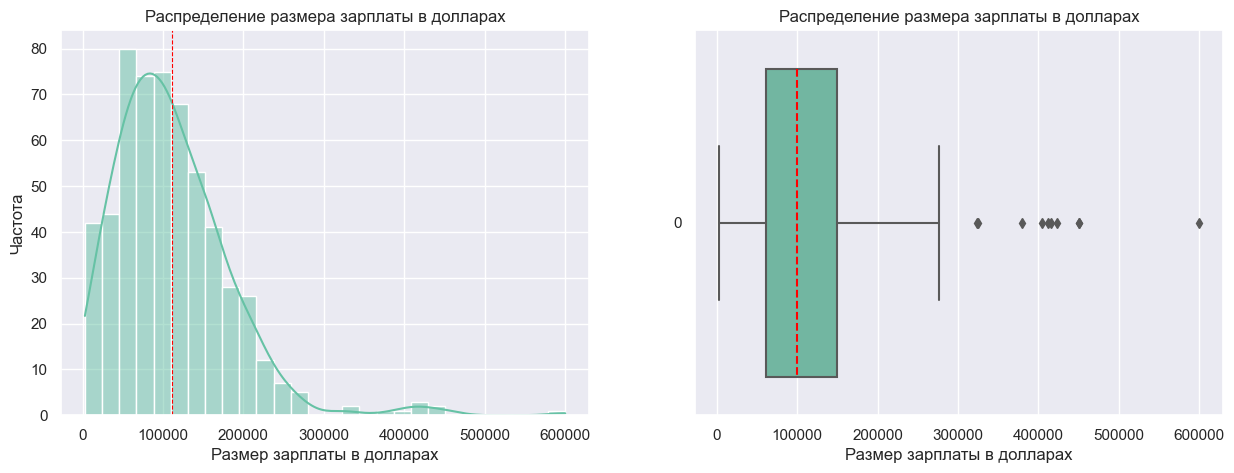

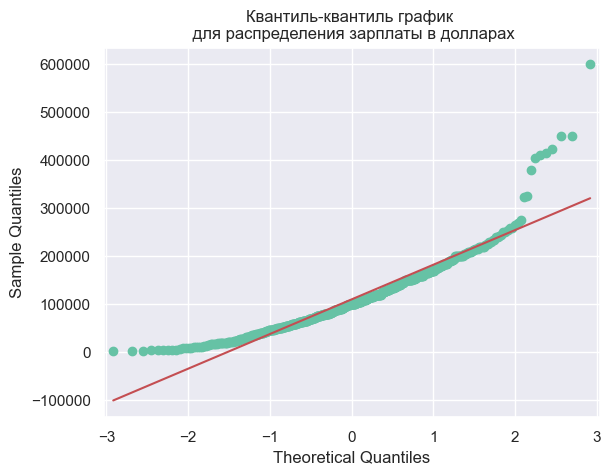

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты в долларах', ylabel='Частота')
axes[0].set_title('Распределение размера зарплаты в долларах')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Размер зарплаты в долларах')
axes[1].set_title('Распределение размера зарплаты в долларах')

sm.qqplot(data['salary_in_usd'], line='s')
plt.title('Квантиль-квантиль график \n для распределения зарплаты в долларах')

plt.show()

In [11]:
desc_frame = round(data['salary_in_usd'].describe(),2).to_frame()
desc_frame.columns = ['Размер зарплаты в долларах']
desc_frame

,Размер зарплаты в долларах
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Уровень зарплат не распределен нормально, имеют место быть правосторонний хвост и выбросы.

### Проанализируем основные статистические характеристики дискретных признаков.

Подсчитаем количество признаков для каждой категории

In [12]:
def find_cat(data):
    for name in data.columns:
        s = ''
        s += name
        if (type(data[name][0]) == str):
            s += ' - признаков: '
            s += str(data[name].nunique())
            print(s)
        
        
find_cat(data)

work_year - признаков: 3
experience_level - признаков: 4
employment_type - признаков: 4
employee_residence - признаков: 57
remote_ratio - признаков: 3
company_location - признаков: 50
company_size - признаков: 3
job_title_prepared - признаков: 3


Подсчитаем количество записей для каждой категории и визуализируем результат

* Признак *'work_year'*

In [13]:
year_frame = data['work_year'].value_counts().to_frame()
year_frame.columns = ['Количество записей']
year_frame['Процентное соотношение'] = round(data['work_year'].value_counts(normalize = True), 2).to_frame()
year_frame = year_frame.sort_index(ascending = True)
year_frame

,Количество записей,Процентное соотношение
2020,72,0.13
2021,215,0.38
2022,278,0.49


In [14]:
fig = go.Figure()
labels = year_frame.index
values = year_frame['Количество записей']

fig = go.Figure()
fig.add_trace(go.Bar(x = labels, y = values, text=values, marker_color='rgb(148, 205, 185)'))
fig.update_layout(
                  title='Годы выплаты зарплата',
                  xaxis_title='Год работы',
                  yaxis_title='Количество записей',
                  width=600,
                  height=500
                  )              
fig.show()

Количество сведения о зарплатах специалистов от года к году увеличивается, что может говорить о увеличении количества вакансий.

* признак *'experience_level'*

In [15]:
experience_frame = data['experience_level'].value_counts().to_frame()
experience_frame.columns = ['Количество записей']
experience = ['Senior-level/Expert', 'Mid-level/Intermediate', 'Entry-level/Junior', 'Executive-level/Director']
experience_frame.insert (0, 'Опыт', experience)
experience_frame['Процентное соотношение'] = round(data['experience_level'].value_counts(normalize = True), 2).to_frame()
experience_frame

,Опыт,Количество записей,Процентное соотношение
SE,Senior-level/Expert,243,0.43
MI,Mid-level/Intermediate,208,0.37
EN,Entry-level/Junior,88,0.16
EX,Executive-level/Director,26,0.05


In [16]:
fig = go.Figure()
labels = experience_frame['Опыт']
values = experience_frame['Количество записей']

fig = go.Figure()
fig.add_trace(go.Bar(x = labels, y = values, text=values, marker_color='rgb(148, 205, 185)'))
fig.update_layout(title='Опыт работы на этой должности в течение года',
                  xaxis_title='Опыт работы',
                  yaxis_title='Количество записей',
                  width=600,
                  height=500
                  )              
fig.show()

Преобладают сведения о зарплатах специалистов уровня Expert и Intermediate.

* признак *'employment_type'*

In [17]:
employment_frame = data['employment_type'].value_counts().to_frame()
employment_frame.columns = ['Количество записей']
employment = ['полный рабочий день', 'неполный рабочий день', 'контракт', 'фриланс']
employment_frame.insert (0, 'Тип трудоустройства', employment)
employment_frame['Процентное соотношение'] = round(data['employment_type'].value_counts(normalize = True), 2).to_frame()
employment_frame

,Тип трудоустройства,Количество записей,Процентное соотношение
FT,полный рабочий день,546,0.97
PT,неполный рабочий день,10,0.02
CT,контракт,5,0.01
FL,фриланс,4,0.01


In [18]:
fig = go.Figure()
labels = employment_frame['Тип трудоустройства']
values = employment_frame['Количество записей']

fig = go.Figure()
fig.add_trace(go.Bar(x = labels, y = values, text=values, marker_color='rgb(148, 205, 185)'))
fig.update_layout(title='Тип трудоустройства для этой роли',
                  xaxis_title='Опыт работы',
                  yaxis_title='Количество записей',
                  width=600,
                  height=500
                  )              
fig.show()

Преобладают занятые полный рабочий день, количество иных видов занятости минимально.

* признак *'employee_residence'*

In [19]:
temp_frame = data['employee_residence'].value_counts().to_frame()
temp_frame.columns = ['Количество записей']
employee_frame = temp_frame[temp_frame['Количество записей'] > 2]
employee_frame['Процентное соотношение'] = round(data['employee_residence'].value_counts(normalize = True), 2).to_frame()
other_record = temp_frame[temp_frame['Количество записей'] < 3].sum()[0] 
other_percent = round((1-employee_frame['Процентное соотношение'].sum()), 2)
employee_frame.loc[len(employee_frame.index)] = [other_record, other_percent]
employee_frame.rename(index={21:'other'}, inplace= True )
employee_frame

,Количество записей,Процентное соотношение
US,295.0,0.52
GB,43.0,0.08
IN,30.0,0.05
CA,27.0,0.05
DE,24.0,0.04
FR,18.0,0.03
ES,15.0,0.03
GR,12.0,0.02
JP,7.0,0.01
PT,6.0,0.01


In [20]:
fig = go.Figure()
labels = employee_frame.index
values = employee_frame['Количество записей']

fig = go.Figure()
fig.add_trace(go.Bar(x = labels, y = values, text=values, marker_color='rgb(148, 205, 185)'))
fig.update_layout(title='Основная страна проживания сотрудника в течение рабочего года',
                  xaxis_title='Страна (кода страны ISO 3166)',
                  yaxis_title='Количество записей',
                  width=1000,
                  height=510
                  )            
fig.show()

В представленном наборе данных основной страной проживания является США - 52%.

* признак *'remote_ratio'*

In [21]:
remote_frame = data['remote_ratio'].value_counts().to_frame()
remote_frame.columns = ['Количество записей']
remote = ['более 80 %', 'менее 20 %', 'частично']
remote_frame.insert (0, 'Общий объём работы', remote)
remote_frame['Процентное соотношение'] = round(data['remote_ratio'].value_counts(normalize = True), 2).to_frame()
remote_frame

,Общий объём работы,Количество записей,Процентное соотношение
100,более 80 %,346,0.61
0,менее 20 %,121,0.21
50,частично,98,0.17


In [22]:
fig = go.Figure()
labels = remote_frame['Общий объём работы']
values = remote_frame['Количество записей']

fig = go.Figure()
fig.add_trace(go.Bar(x = labels, y = values, text=values, marker_color='rgb(148, 205, 185)'))
fig.update_layout(title='Общий объём работы, выполняемой удалённо',
                  xaxis_title='Объём работы',
                  yaxis_title='Количество записей',
                  width=600,
                  height=500
                  )              
fig.show()

По представленным данным из выполняемой удаленно работы более 80% объёма работы выполняется удаленно.

* признак *'company_location'*

In [23]:
temp_frame = data['company_location'].value_counts().to_frame()
temp_frame.columns = ['Количество записей']
company_frame = temp_frame[temp_frame['Количество записей'] > 2]
company_frame['Процентное соотношение'] = round(data['company_location'].value_counts(normalize = True), 2).to_frame()
other_record = temp_frame[temp_frame['Количество записей'] < 3].sum()[0] 
other_percent = round((1-company_frame['Процентное соотношение'].sum()), 2)
company_frame.loc[len(company_frame.index)] = [other_record, other_percent]
company_frame.rename(index={21:'other'}, inplace= True )
company_frame

,Количество записей,Процентное соотношение
US,318.0,0.56
GB,46.0,0.08
CA,28.0,0.05
DE,27.0,0.05
IN,24.0,0.04
FR,15.0,0.03
ES,14.0,0.02
GR,10.0,0.02
JP,6.0,0.01
NL,4.0,0.01


In [24]:
fig = go.Figure()
labels = company_frame.index
values = company_frame['Количество записей']

fig = go.Figure()
fig.add_trace(go.Bar(x = labels, y = values, text=values, marker_color='rgb(148, 205, 185)'))
fig.update_layout(title='Страна главного офиса работодателя или филиала по контракту',
                  xaxis_title='Страна (кода страны ISO 3166)',
                  yaxis_title='Количество записей',
                  width=1000,
                  height=500
                  )              
fig.show()

По представленным данным, главный офис располагается преимущественно в США - 56%.

* признак *'company_size'*

In [25]:
size_frame = data['company_size'].value_counts().to_frame()
size_frame.columns = ['Количество записей']
size = ['от 50 до 250', 'более 250','менее 50']
size_frame.insert (0, 'Среднее количество сотрудников', size)
size_frame['Процентное соотношение'] = round(data['company_size'].value_counts(normalize = True), 2).to_frame()
size_frame

,Среднее количество сотрудников,Количество записей,Процентное соотношение
M,от 50 до 250,290,0.51
L,более 250,193,0.34
S,менее 50,82,0.15


In [26]:
fig = go.Figure()
labels = size_frame['Среднее количество сотрудников']
values = size_frame['Количество записей']

fig = go.Figure()
fig.add_trace(go.Bar(x = labels, y = values, text=values, marker_color='rgb(148, 205, 185)'))
fig.update_layout(title='Среднее количество сотрудников, работавших в течении года',
                  xaxis_title='Среднее количество сотрудников',
                  yaxis_title='Количество записей',
                  width=600,
                  height=500
                  )              
fig.show()

В представленных данных преобладают компании со средним количеством сотрудников.

* признак *'job_title_prepared'*

In [27]:
job_frame = data['job_title_prepared'].value_counts().to_frame()
job_frame.columns = ['Количество записей']
job_frame['Процентное соотношение'] = round(data['job_title_prepared'].value_counts(normalize = True), 2).to_frame()
job_frame

,Количество записей,Процентное соотношение
other,272,0.48
Data Engineer,147,0.26
Data Scientist,146,0.26


In [28]:
fig = go.Figure()
labels = job_frame.index
values = job_frame['Количество записей']

fig = go.Figure()
fig.add_trace(go.Bar(x = labels, y = values, text=values, marker_color='rgb(148, 205, 185)'))
fig.update_layout(title='Роль, в которой соискатель работал в течении года',
                  xaxis_title='Роль, в которой работал соискатель',
                  yaxis_title='Количество записей',
                  width=600,
                  height=500
                  )              
fig.show()

В представленном датафрейме основная масса работников не относится к категориям Data Engineer и Data Scientist, количество же последних, практически равно.

### Зарплата по годам для специальности Data Scientist

In [29]:
# подготовка данных
data_DS = data[data['job_title_prepared'] == 'Data Scientist']
data_DS['company_size'] = data_DS['company_size'].replace(['S', 'M', 'L'],
            ['менее 50', 'от 50 до 250', 'более 250'])
data_DS['remote_ratio'] = data_DS['remote_ratio'].replace(['0', '50', '100'],
            ['менее 20 %', 'частично', 'более 80 %'])
data_DS['employment_type'] = data_DS['employment_type'].replace(['FT', 'PT', 'CT', 'FL'],
            ['полный рабочий день', 'неполный рабочий день', 'контракт', 'фриланс'])
data_DS['experience_level'] = data_DS['experience_level'].replace(['EN', 'MI', 'SE', 'EX'],
            ['Entry-level/Junior', 'Mid-level/Intermediate', 'Senior-level/Expert', 
             'Executive-level/Director'])

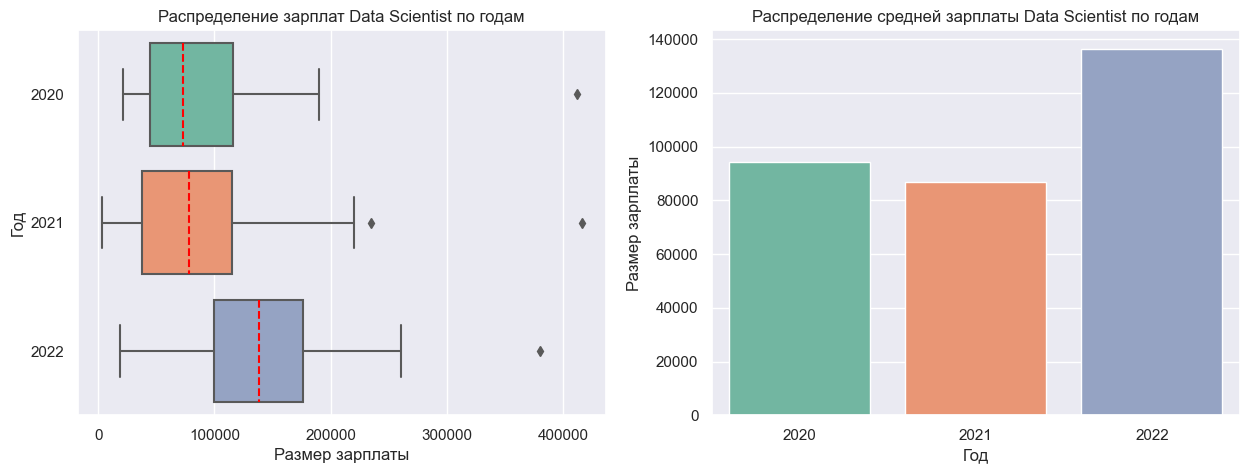

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=data_DS, x='salary_in_usd', y='work_year', 
            medianprops={"color": "red", "linestyle": '--'},
            ax = axes[0])
axes[0].set(xlabel='Размер зарплаты', ylabel='Год')
axes[0].set_title('Распределение зарплат Data Scientist по годам')

sns.barplot(data=data_DS, x='work_year', y='salary_in_usd',
            orient='v', ax = axes[1], ci=None)
axes[1].set(ylabel='Размер зарплаты', xlabel='Год')
axes[1].set_title('Распределение средней зарплаты Data Scientist по годам')

plt.show()

In [31]:
data_agg = data_DS.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Зарплата Data Scientist по годам')
data_agg = data_agg.sort_values(by='mean', axis=0, ascending=False)
data_agg

Зарплата Data Scientist по годам


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2022,69.0,136456.88,62180.70,18442.0,99360.00,138600.0,176000.0,380000.0
2020,24.0,94110.08,79835.00,21669.0,44869.25,72693.0,115750.0,412000.0
2021,53.0,86700.02,71562.65,2859.0,37825.00,77684.0,115000.0,416000.0


На первый взгляд в период 2020 - 2022 год наблюдается рост зарплат специалистов Data Scientist. Для того, что бы определить, является ли статистически значимым это предположени необходимо провести статистическое тестирование.

### Исследуем факторы, влияющие на зарплату специалиста Data Scientist.

Оценим влияние признака "Опыт работы на этой должности в течение года" на зарплату специалиста Data Scientist.

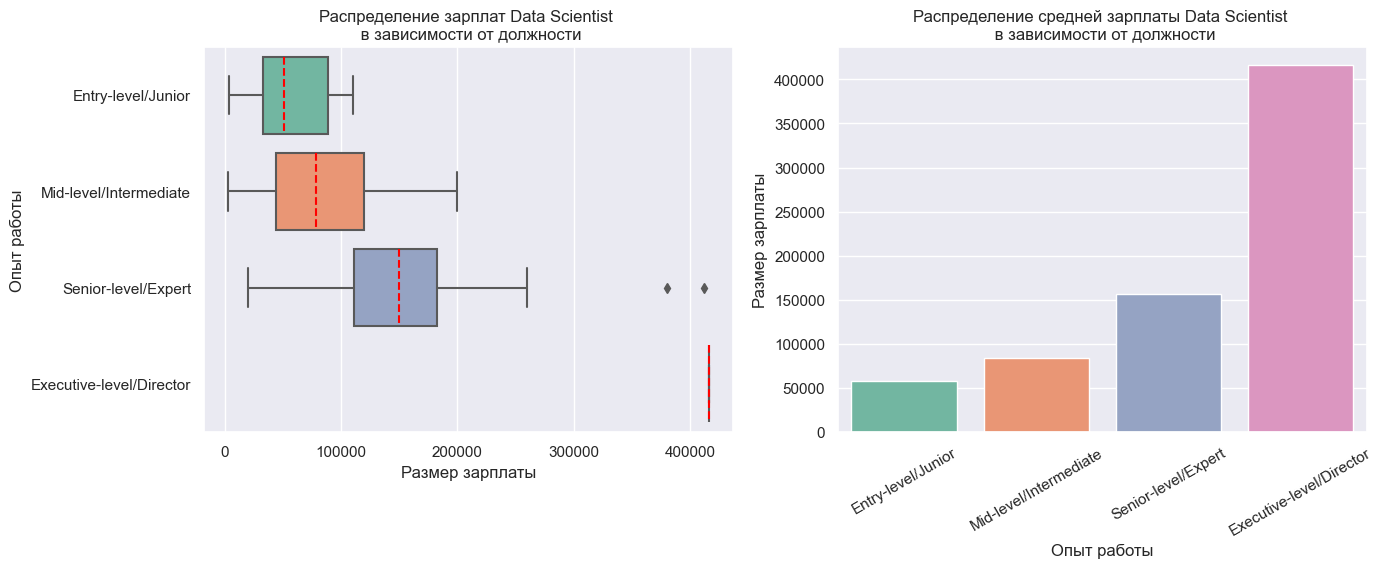

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=data_DS, x='salary_in_usd', y='experience_level', 
            medianprops={"color": "red", "linestyle": '--'},
            order = ['Entry-level/Junior', 'Mid-level/Intermediate', 'Senior-level/Expert',  'Executive-level/Director'],
            ax = axes[0])
axes[0].set(xlabel='Размер зарплаты', ylabel='Опыт работы')
axes[0].set_title('Распределение зарплат Data Scientist \n в зависимости от должности')

sns.barplot(data=data_DS, x='experience_level', y='salary_in_usd',
            order = ['Entry-level/Junior', 'Mid-level/Intermediate', 'Senior-level/Expert',  'Executive-level/Director'],
            orient='v', ax = axes[1], ci=None)
axes[1].set(ylabel='Размер зарплаты', xlabel='Опыт работы')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 30)
axes[1].set_title('Распределение средней зарплаты Data Scientist \n в зависимости от должности')

plt.show()

In [33]:
data_agg = data_DS.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Зарплата Data Scientist в зависимости от должности')
data_agg = data_agg.sort_values(by='mean', axis=0, ascending=False)
data_agg

Зарплата Data Scientist в зависимости от должности


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
Executive-level/Director,1.0,416000.00,NaN,416000.0,416000.0,416000.0,416000.0,416000.0
Senior-level/Expert,59.0,156222.02,68208.99,20171.0,111394.5,150000.0,182550.0,412000.0
Mid-level/Intermediate,63.0,84267.49,47765.27,2859.0,43978.5,78000.0,119529.5,200000.0
Entry-level/Junior,23.0,57709.43,32581.69,4000.0,33197.0,51321.0,88351.5,110037.0


По полученным данным можно предположить, что уровень зарплаты корелируется с уровнем занимаемой должности. Для того, что бы определить, является ли статистически значимым это предположение необходимо дополнительно провести статистическое тестирование.

Оценим влияние признака "Тип трудоустройства для этой роли" на зарплату специалиста Data Scientist.

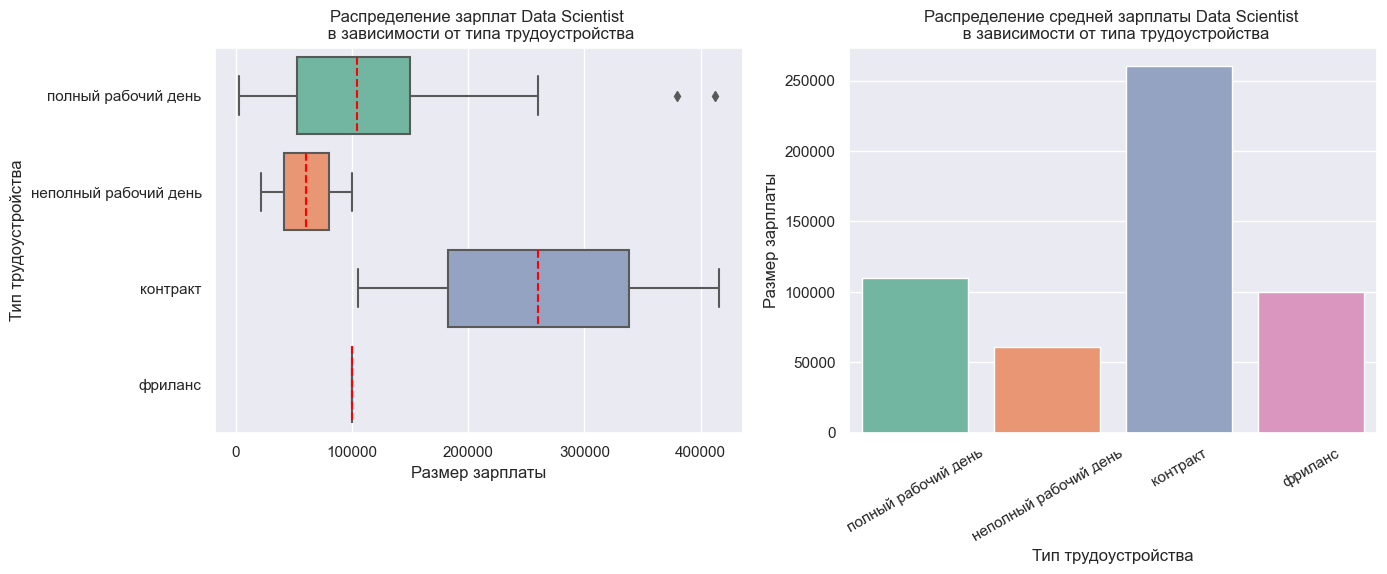

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=data_DS, x='salary_in_usd', y='employment_type', 
            medianprops={"color": "red", "linestyle": '--'},
            ax = axes[0])
axes[0].set(xlabel='Размер зарплаты', ylabel='Тип трудоустройства')
axes[0].set_title('Распределение зарплат Data Scientist \n в зависимости от типа трудоустройства')

sns.barplot(data=data_DS, x='employment_type', y='salary_in_usd',
            orient='v', ax = axes[1], ci=None)
axes[1].set(ylabel='Размер зарплаты', xlabel='Тип трудоустройства')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 30)
axes[1].set_title('Распределение средней зарплаты Data Scientist \n в зависимости от типа трудоустройства')

plt.show()

In [35]:
data_agg = data_DS.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Распределение средней зарплаты Data Scientist в зависимости от типа трудоустройства')
data_agg = data_agg.sort_values(by='mean', axis=0, ascending=False)
data_agg

Распределение средней зарплаты Data Scientist в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
контракт,2.0,260500.00,219910.21,105000.0,182750.00,260500.0,338250.00,416000.0
полный рабочий день,141.0,110117.72,68519.01,2859.0,53192.00,104702.0,150000.00,412000.0
фриланс,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
неполный рабочий день,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


По полученным данным можно предположить, что уровень зарплаты коррелируется с типом трудоустройства, наибольший при полном рабочем дне и наименьший при неполном рабочем дне. Для того, что бы определить, является ли статистически значимым это предположение необходимо дополнительно провести статистическое тестирование.

Оценим влияние признака "Основная страна проживания сотрудника в течение рабочего года" на зарплату специалиста Data Scientist.

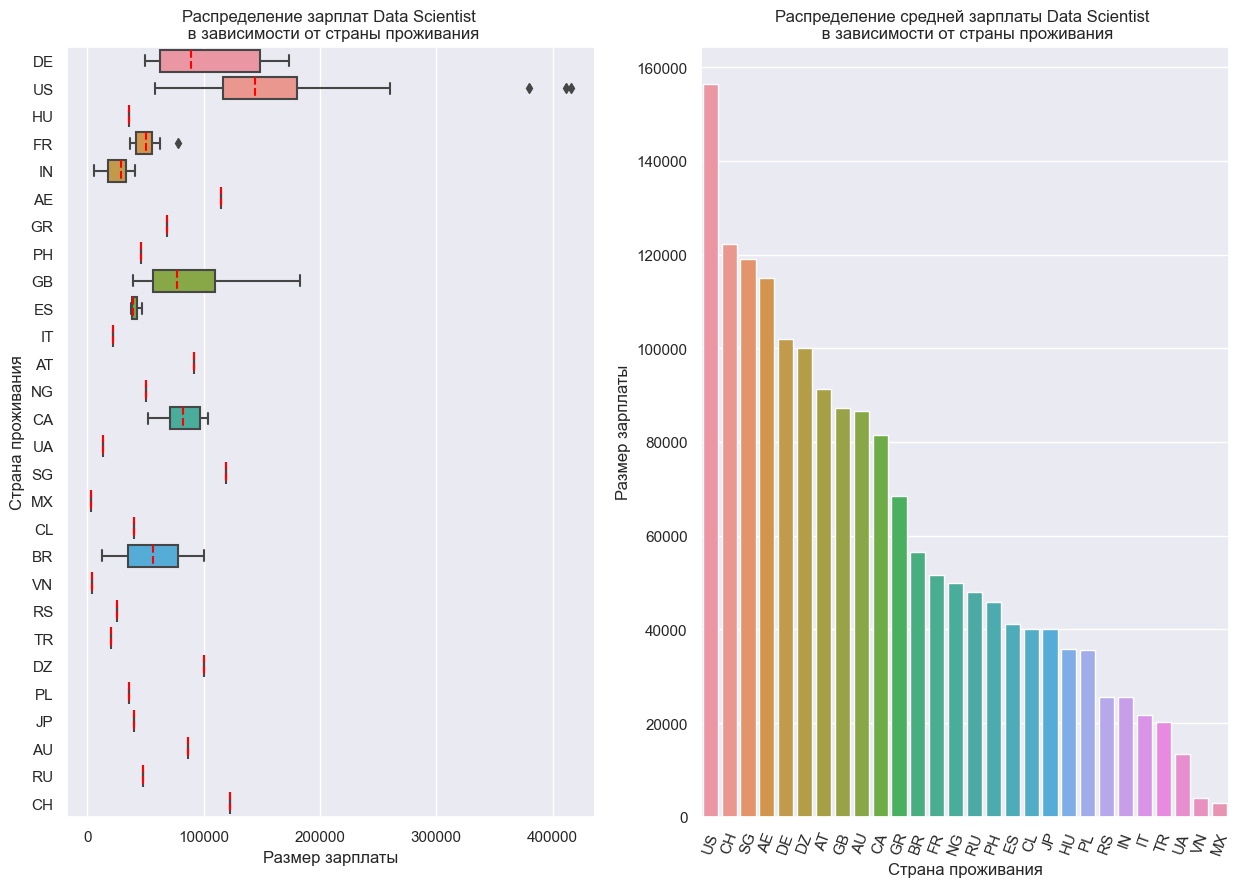

In [36]:
employee_data = data_DS.groupby('employee_residence')['salary_in_usd'].agg(['mean'])
employee_data = employee_data.sort_values(by='mean', axis=0, ascending=False)
employee_data.reset_index(inplace= True )


fig, axes = plt.subplots(1, 2, figsize=(15, 10))

sns.boxplot(data=data_DS, x='salary_in_usd', y='employee_residence', 
            medianprops={"color": "red", "linestyle": '--'},
            ax = axes[0])
axes[0].set(xlabel='Размер зарплаты', ylabel='Страна проживания')
axes[0].set_title('Распределение зарплат Data Scientist \n в зависимости от страны проживания')

sns.barplot(data=employee_data, x='employee_residence', y='mean',
            orient='v', ax = axes[1], ci=None)
axes[1].set(ylabel='Размер зарплаты', xlabel='Страна проживания')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 70)
axes[1].set_title('Распределение средней зарплаты Data Scientist \n в зависимости от страны проживания')

plt.show()

In [37]:
data_agg = data_DS.groupby('employee_residence')['salary_in_usd'].describe().round(2)
print('Распределение средней зарплаты Data Scientist в зависимости от страны проживания')
data_agg = data_agg.sort_values(by='count', axis=0, ascending=False)
data_agg

Распределение средней зарплаты Data Scientist в зависимости от страны проживания


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
US,75.0,156512.67,66842.63,58000.0,116500.00,144000.0,180000.00,416000.0
GB,13.0,87248.15,39531.34,39263.0,56256.00,76958.0,110037.00,183228.0
IN,10.0,25511.50,12284.10,5679.0,17288.50,29075.0,33259.75,40570.0
DE,9.0,101931.00,47081.85,49268.0,62726.00,88654.0,148261.00,173762.0
FR,8.0,51665.62,13412.16,36643.0,41626.75,50483.5,55575.50,77684.0
CA,6.0,81489.17,19500.74,52396.0,70945.50,81756.0,96934.50,103691.0
ES,3.0,41136.67,4935.34,37825.0,38300.50,38776.0,42792.50,46809.0
BR,2.0,56450.50,61588.29,12901.0,34675.75,56450.5,78225.25,100000.0
RU,1.0,48000.00,NaN,48000.0,48000.00,48000.0,48000.00,48000.0


По полученным данным можно предположить, что уровень зарплаты корелируется со страной проживания, наибольший с заметным отрывом в США. Для того, что бы определить, является ли статистически значимым это предположение необходимо дополнительно провести статистическое тестирование.

Оценим влияние признака "Общий объём работы, выполняемой удалённо" на зарплату специалиста Data Scientist.


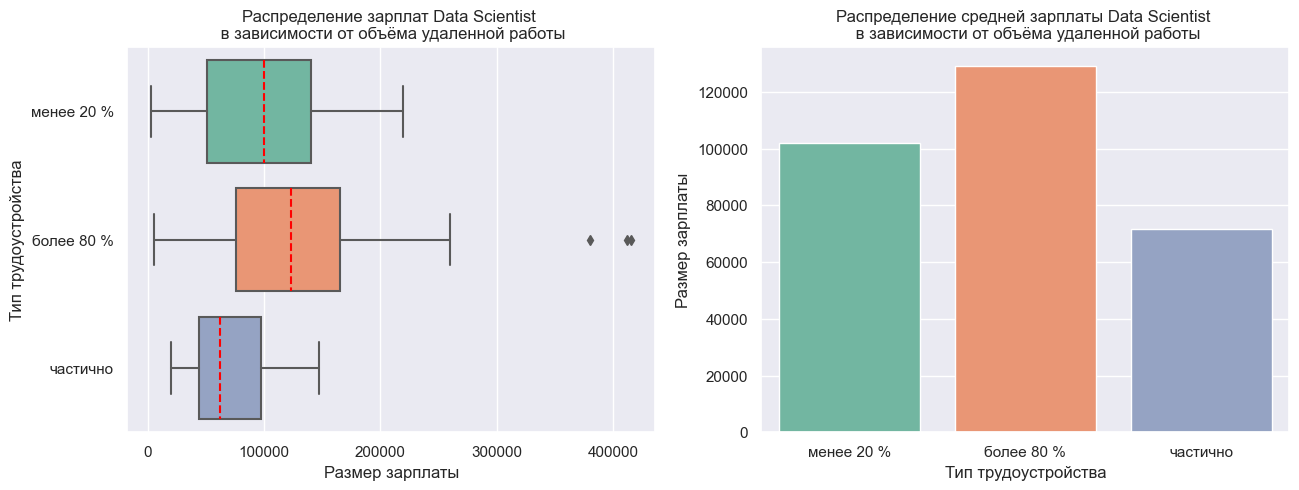

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=data_DS, x='salary_in_usd', y='remote_ratio', 
            medianprops={"color": "red", "linestyle": '--'},
            ax = axes[0])
axes[0].set(xlabel='Размер зарплаты', ylabel='Тип трудоустройства')
axes[0].set_title('Распределение зарплат Data Scientist \n в зависимости от объёма удаленной работы')

sns.barplot(data=data_DS, x='remote_ratio', y='salary_in_usd',
            orient='v', ax = axes[1], ci=None)
axes[1].set(ylabel='Размер зарплаты', xlabel='Тип трудоустройства')
axes[1].set_title('Распределение средней зарплаты Data Scientist \n в зависимости от объёма удаленной работы')

plt.show()

In [39]:
data_agg = data_DS.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Распределение средней зарплаты Data Scientist в зависимости от объёма удаленной работы')
data_agg = data_agg.sort_values(by='mean', axis=0, ascending=False)
data_agg

Распределение средней зарплаты Data Scientist в зависимости от объёма удаленной работы


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
более 80 %,79.0,129324.63,81295.77,5679.0,76366.00,123000.0,165110.0,416000.0
менее 20 %,41.0,102096.24,59560.99,2859.0,51321.00,100000.0,140400.0,220000.0
частично,26.0,71795.23,35513.10,20171.0,44059.25,62096.5,97683.5,147000.0


По полученным данным можно предположить, что уровень зарплаты корелируется с объёмом работы, выполненной удаленно, наибольший при объёме более 80%. Для того, что бы определить, является ли статистически значимым это предположение необходимо дополнительно провести статистическое тестирование.

Оценим влияние признака "Страна главного офиса работодателя или филиала по контракту" на зарплату специалиста Data Scientist.


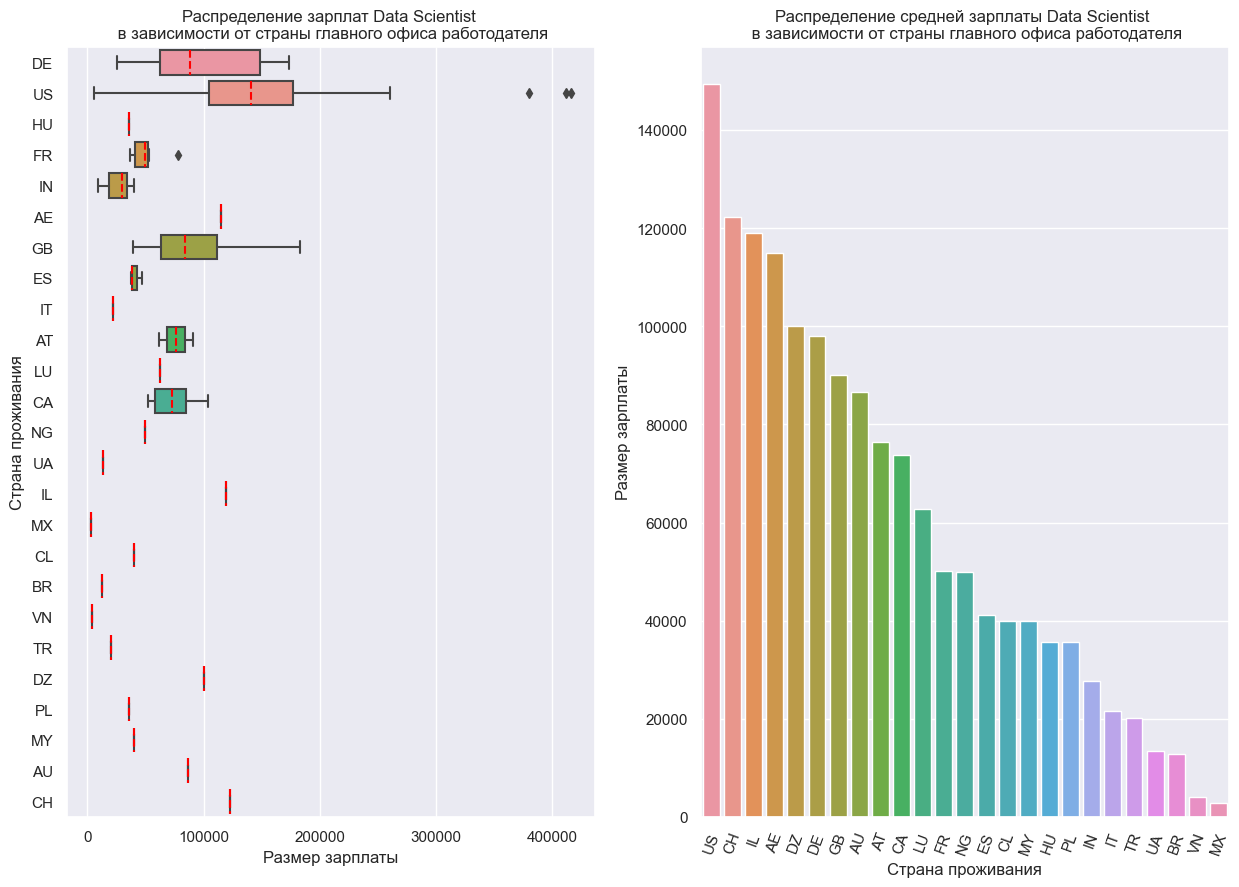

In [40]:
company_data = data_DS.groupby('company_location')['salary_in_usd'].agg(['mean'])
company_data = company_data.sort_values(by='mean', axis=0, ascending=False)
company_data.reset_index(inplace= True )


fig, axes = plt.subplots(1, 2, figsize=(15, 10))

sns.boxplot(data=data_DS, x='salary_in_usd', y='company_location', 
            medianprops={"color": "red", "linestyle": '--'},
            ax = axes[0])
axes[0].set(xlabel='Размер зарплаты', ylabel='Страна проживания')
axes[0].set_title('Распределение зарплат Data Scientist \n в зависимости от страны главного офиса работодателя')

sns.barplot(data=company_data, x='company_location', y='mean',
            orient='v', ax = axes[1], ci=None)
axes[1].set(ylabel='Размер зарплаты', xlabel='Страна проживания')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 70)
axes[1].set_title('Распределение средней зарплаты Data Scientist \n в зависимости от страны главного офиса работодателя')

plt.show()

In [41]:
data_agg = data_DS.groupby('company_location')['salary_in_usd'].describe().round(2)
print('Распределение средней зарплаты Data Scientist в зависимости от страны офиса главного офиса работодателя')
data_agg = data_agg.sort_values(by='count', axis=0, ascending=False)
data_agg

Распределение средней зарплаты Data Scientist в зависимости от страны офиса главного офиса работодателя


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
US,81.0,149460.70,69600.41,5679.0,105000.0,140400.0,177000.00,416000.0
GB,12.0,89999.00,39968.45,39263.0,63142.5,84286.0,111756.25,183228.0
DE,9.0,97938.22,52189.08,25532.0,62726.0,88654.0,148261.00,173762.0
IN,9.0,27715.11,10729.99,9466.0,18442.0,29751.0,33808.00,40570.0
FR,7.0,50085.57,13658.91,36643.0,41056.5,49646.0,52256.50,77684.0
CA,6.0,73862.17,19760.28,52396.0,58012.5,72555.0,84747.00,103691.0
ES,3.0,41136.67,4935.34,37825.0,38300.5,38776.0,42792.50,46809.0
AT,2.0,76352.00,21050.57,61467.0,68909.5,76352.0,83794.50,91237.0
AE,1.0,115000.00,NaN,115000.0,115000.0,115000.0,115000.00,115000.0


По полученным данным можно предположить, что уровень зарплаты корелируется с расположением страны офиса работодателя, наибольший для офисов в США. Для того, что бы определить, является ли статистически значимым это предположение необходимо дополнительно провести статистическое тестирование.

Оценим влияние признака "Среднее количество людей, работавших в компании в течение года" на зарплату специалиста Data Scientist.

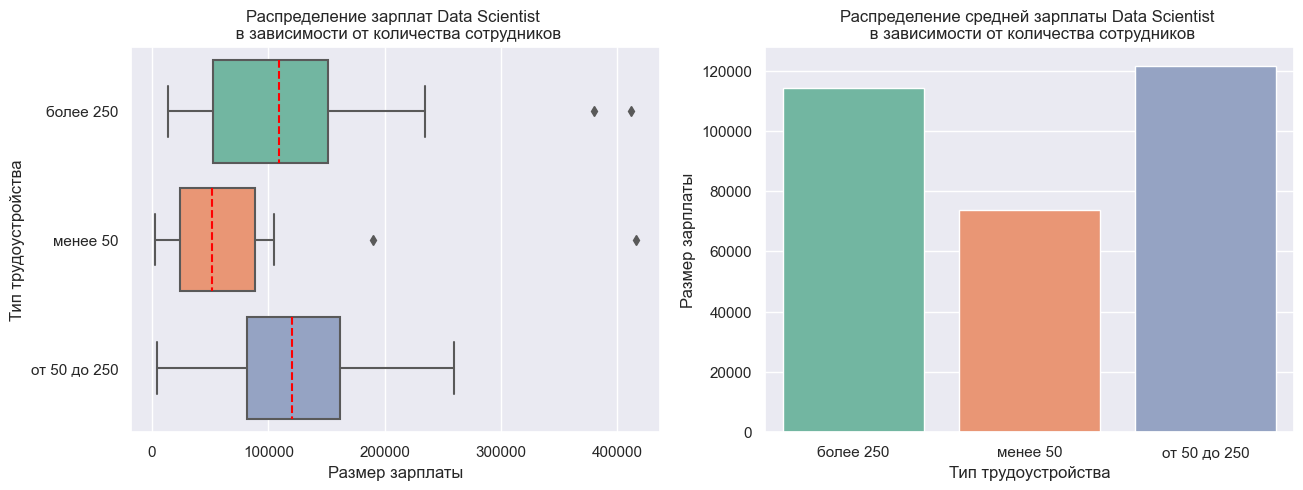

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=data_DS, x='salary_in_usd', y='company_size', 
            medianprops={"color": "red", "linestyle": '--'},
            ax = axes[0])
axes[0].set(xlabel='Размер зарплаты', ylabel='Тип трудоустройства')
axes[0].set_title('Распределение зарплат Data Scientist \n в зависимости от количества сотрудников')

sns.barplot(data=data_DS, x='company_size', y='salary_in_usd',
            orient='v', ax = axes[1], ci=None)
axes[1].set(ylabel='Размер зарплаты', xlabel='Тип трудоустройства')
axes[1].set_title('Распределение средней зарплаты Data Scientist \n в зависимости от количества сотрудников')

plt.show()

In [43]:
data_agg = data_DS.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение средней зарплаты Data Scientist в зависимости от количества сотрудников')
data_agg = data_agg.sort_values(by='mean', axis=0, ascending=False)
data_agg

Распределение средней зарплаты Data Scientist в зависимости от количества сотрудников


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
от 50 до 250,70.0,121643.07,55420.17,4000.0,81675.75,120080.0,162005.5,260000.0
более 250,53.0,114298.34,81290.41,13400.0,52396.00,109000.0,151000.0,412000.0
менее 50,23.0,73758.30,86001.53,2859.0,23600.50,51321.0,88869.0,416000.0


По полученным данным можно предположить, что уровень зарплаты корелируется с количеством сотрудников наибольший для количества сотрудников в интервале 50 - 250. Для того, что бы определить, является ли статистически значимым это предположение необходимо дополнительно провести статистическое тестирование.

### Исследуем соотношение зарплаты Data Scientist и Data Engineer в различных компаниях

В датасете отсутсвуют сведения о компании - работодателе, в связи с этим рассмотрим соотношение зарплаты Data Scientist и Data Engineer по всему датасету.


In [44]:
# подготовка данных
solary_data = data[((data['job_title_prepared'] == 'Data Scientist') | (data['job_title_prepared'] == 'Data Engineer'))]

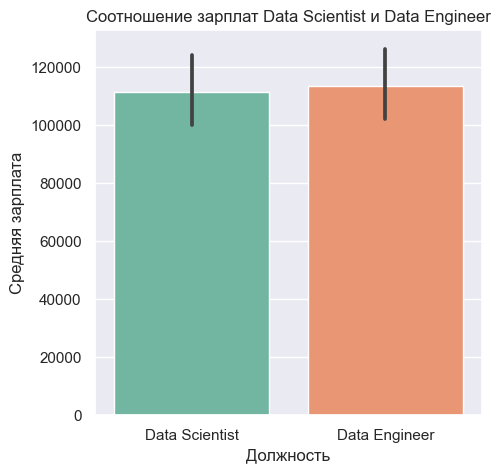

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='job_title_prepared', y='salary_in_usd',  data=solary_data, ax = axes)
axes.set(xlabel='Должность', ylabel='Средняя зарплата')
axes.set_title('Соотношение зарплат Data Scientist и Data Engineer')

plt.show()

In [46]:
print('Распределение средней зарплаты Data Scientist и Data Engineer')
data_agg = solary_data.groupby('job_title_prepared')['salary_in_usd'].describe().round(2)
data_agg = data_agg.sort_values(by='mean', axis=0, ascending=False)
data_agg

Распределение средней зарплаты Data Scientist и Data Engineer


,count,mean,std,min,25%,50%,75%,max
job_title_prepared,,,,,,,,
Data Engineer,147.0,113590.47,71848.71,4000.0,65985.5,104702.0,153500.0,600000.0
Data Scientist,146.0,111433.34,72332.81,2859.0,53453.5,104196.5,150000.0,416000.0


На первый взгляд наблюдается не большая разница зарплат специалистов Data Scientist и Data Engineer. Для того, что бы определить, является ли статистически значимым это предположени необходимо провести статистическое тестирование.

### Связь размера компании и наличия должностей Data Scientist и Data Engineer

In [47]:
company_size_data = data[['job_title_prepared','company_size']]
company_size_data['job_type'] = company_size_data['job_title_prepared'].apply(lambda x: 'other' if x == 'other' else 'Data Scientist_Data Engineer')
company_size_data = company_size_data.drop(['job_title_prepared'], axis = 1)
company_size_data['company_size'] = company_size_data['company_size'].replace(['S', 'M', 'L'],
            ['менее 50', 'от 50 до 250', 'более 250'])
cross_tab = pd.crosstab(index=company_size_data['company_size'], columns=company_size_data['job_type'])

count_data = data.copy()
count_data['company_size'] = count_data['company_size'].replace(['S', 'M', 'L'],
            ['менее 50', 'от 50 до 250', 'более 250'])

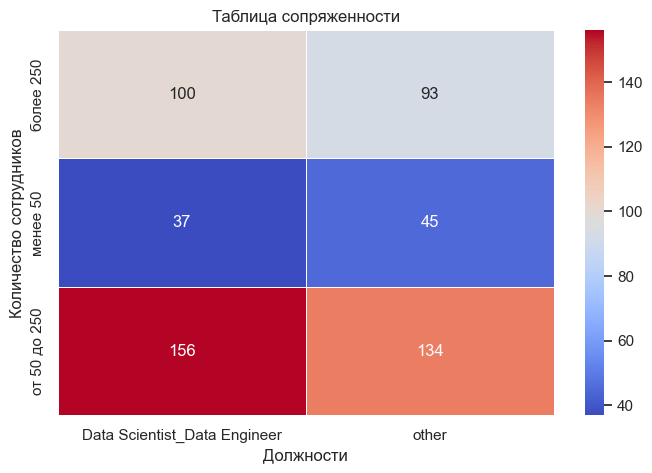

In [48]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))

sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm", ax = axes)
axes.set(xlabel='Должности', ylabel='Количество сотрудников')
axes.set_title('Таблица сопряженности')

plt.show()

In [49]:
print('Количество вакансий Data Scientist, Data Engineer и иных должностей в зависимости от размера компании')

temp_data = count_data.pivot_table(
    values='salary_in_usd',
    index='company_size',
    columns='job_title_prepared',
    aggfunc=['count'],
    fill_value=0
)

data_company_size = pd.DataFrame()
data_company_size['Data Engineer'] = temp_data['count']['Data Engineer']
data_company_size['Data Scientist'] = temp_data['count']['Data Scientist']
data_company_size['other'] = temp_data['count']['other']
data_company_size['all'] = data_company_size[['Data Engineer', 'Data Scientist', 'other']].sum(axis=1)
data_company_size['Data Engineer percent'] = round(data_company_size['Data Engineer'] /
                    data_company_size['all']*100, 2)
data_company_size['Data Scientist percent'] = round(data_company_size['Data Scientist'] /
                    data_company_size['all']*100, 2)
data_company_size['Data Engineer and Data Scientist percent'] = data_company_size[['Data Engineer percent',
                    'Data Scientist percent']].sum(axis=1)
data_company_size

Количество вакансий Data Scientist, Data Engineer и иных должностей в зависимости от размера компании


,Data Engineer,Data Scientist,other,all,Data Engineer percent,Data Scientist percent,Data Engineer and Data Scientist percent
company_size,,,,,,,
более 250,47,53,93,193,24.35,27.46,51.81
менее 50,14,23,45,82,17.07,28.05,45.12
от 50 до 250,86,70,134,290,29.66,24.14,53.80


На первый взгляд можно предположить наличие связи между наличием должностей Data Scientist и Data Engineer и размером компании. Наибольшее количество в компаниях среднего размера, причём количество Data Engineer больше, в маленьких и крупных компаниях обратная зависимость. Что бы установить является ли данное предположеие статистически значимым необходимо провести статистическое тестирование.

### Исследуем соотношение зарплаты Data Scientist и Data Engineer в зависимости от страны проживания

In [50]:
# подготовка данных
temp_data=data[((data['job_title_prepared'] == 'Data Scientist') | (data['job_title_prepared'] == 'Data Engineer'))]
data_residence = temp_data.pivot_table(
    values='salary_in_usd',
    index='employee_residence',
    columns='job_title_prepared',
    aggfunc=['mean'],
    fill_value=0
)
tab_data_residence = pd.DataFrame()
graf_data = tab_data = pd.DataFrame()
tab_data_residence['Data Engineer'] = data_residence['mean']['Data Engineer']
tab_data_residence['Data Scientist'] = data_residence['mean']['Data Scientist']
graf_data = tab_data_residence.stack().reset_index(level=1)
graf_data.columns = ['Должность', 'value']

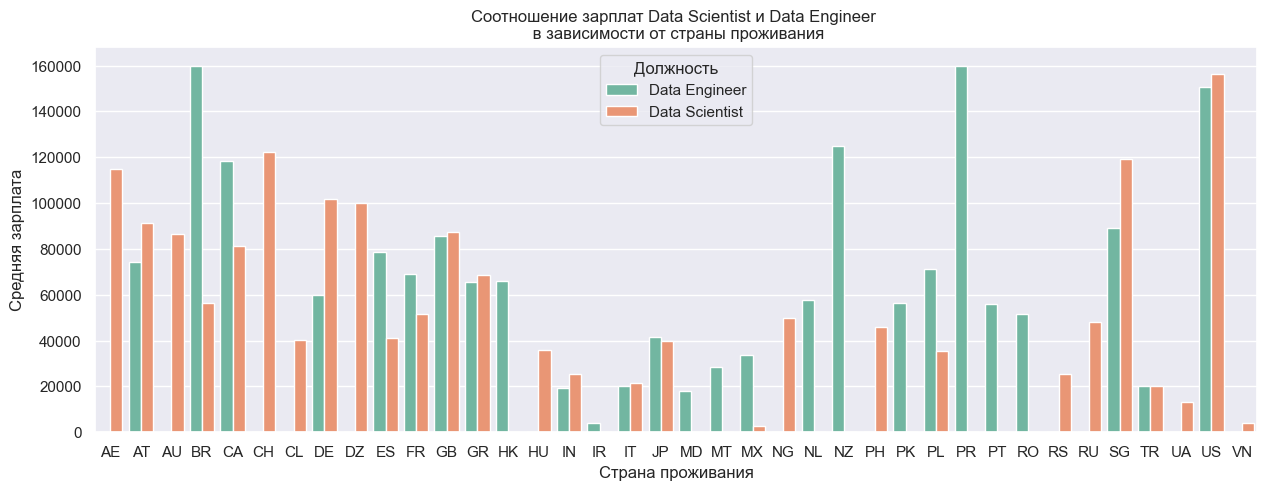

In [51]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(x=graf_data.index.values, y='value', hue='Должность', data=graf_data, ax = axes)
axes.set(xlabel='Страна проживания', ylabel='Средняя зарплата')
axes.set_title('Соотношение зарплат Data Scientist и Data Engineer \n в зависимости от страны проживания')

plt.show()

In [52]:
print('Распределение средней зарплаты Data Scientist и Data Engineer в зависимости от страны проживания')
tab_data_residence

Распределение средней зарплаты Data Scientist и Data Engineer в зависимости от страны проживания


,Data Engineer,Data Scientist
employee_residence,,
AE,0.000000,115000.000000
AT,74130.000000,91237.000000
AU,0.000000,86703.000000
BR,160000.000000,56450.500000
CA,118187.000000,81489.166667
CH,0.000000,122346.000000
CL,0.000000,40038.000000
DE,59757.666667,101931.000000
DZ,0.000000,100000.000000


На первый взгляд наблюдается разница зарплат специалистов Data Scientist и Data Engineer, проживающих в различных странах. Для того, что бы определить, является ли статистически значимым это предположени необходимо провести статистическое тестирование.

### Медианная зарплата Data Scientist больше 100000$?


In [53]:
# подготовка данных
boxplot_data=data[(data['job_title_prepared'] == 'Data Scientist')]

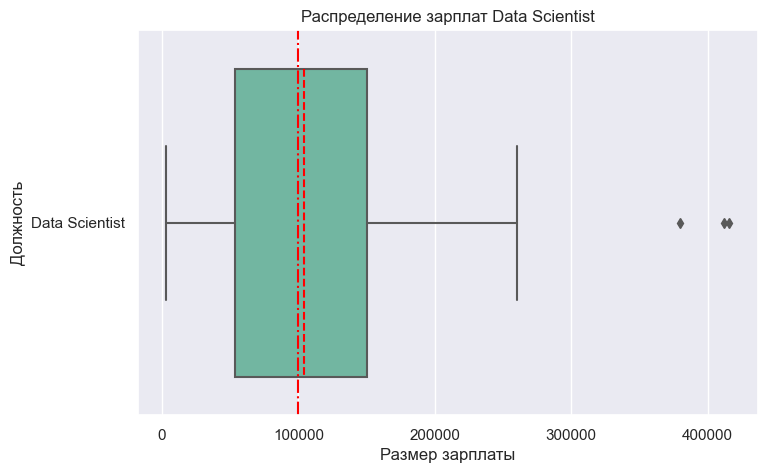

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(data=boxplot_data, x='salary_in_usd', y='job_title_prepared', 
            medianprops={"color": "red", "linestyle": '--'},
            ax = axes)
axes.set(xlabel='Размер зарплаты', ylabel='Должность')
axes.set_title('Распределение зарплат Data Scientist')

plt.axvline(x=100000, color = 'red', linestyle = '-.')

plt.show()

In [55]:
print('Медианная зарплата Data Scientist = {}'.format(round(boxplot_data.salary_in_usd.median(), 2)))

Медианная зарплата Data Scientist = 104196.5


На первый взгляд можно предположить, что средний уровень зарплаты Data Scientist выше 100 000$. Чтобы установить является ли данное предположеие статистически значимым необходимо провести статистическое тестирование.

## Статистический анализ данных

In [56]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
  

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер средней зарплаты у специалистов Data Scientist не отличается на интревале лет: 2020 - ($μ_1$), 2021 - ($μ_2$), 2022 - ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер средней зарплаты у специалистов Data Scientist статистически ежегодно увеличивается на интервале лет: 2020 - ($μ_1$), 2021 - ($μ_2$), 2022 - ($μ_3$).

$$ H_1 : μ_1 < μ_2 < μ_3$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.

In [57]:
# значения зарплат
salary_2020 = data.loc[data['work_year']=='2020', 'salary_in_usd']
salary_2021 = data.loc[data['work_year']=='2021', 'salary_in_usd']
salary_2022 = data.loc[data['work_year']=='2022', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для 2020 года:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021 года:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022 года:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

Для 2020 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2022 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [58]:
# проводим тест
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть основание утверждать, что размер средней зарплаты у специалистов Data Scientist ежегодно увеличивается.

### Какие факторы влияют на зарплату у специалистов Data Scientist?

Для ответа на этот вопрос необходимо оценить влияние на уровень зарплаты специалистов Data Scientist следующих факторов:
- experience_level - "Опыт работы на этой должности в течение года"
- employment_type - "Тип трудоустройства"
- employee_residence - "Основная страна проживания сотрудника в течение рабочего года"
- remote_ratio - "Общий объём работы, выполняемой удалённо"
- company_location - "Страна главного офиса работодателя или филиала по контракту"
- company_size - "Среднее количество людей, работавших в компании в течение года"

**Оценим влияние признака "Опыт работы на этой должности в течение года"**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер средней зарплаты у специалистов Data Scientist не зависит от опыта работы и одинаков для: Entry-level/Junior - ($μ_1$), Mid-level/Intermediate - ($μ_2$), Senior-level/Expert - ($μ_3$),  Executive-level/Director - ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза* ($H_1$): размер средней зарплаты у специалистов Data Scientist зависит от опыта работы и отличается для: Entry-level/Junior - ($μ_1$), Mid-level/Intermediate - ($μ_2$), Senior-level/Expert - ($μ_3$),  Executive-level/Director - ($μ_4$).

$$ H_1 : μ_1 < μ_2 < μ_3 < μ_4$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.

In [59]:
# значения зарплат
experience_Junior = data.loc[data['experience_level']=='EN', 'salary_in_usd']
experience_Intermediate = data.loc[data['experience_level']=='MI', 'salary_in_usd']
experience_Expert = data.loc[data['experience_level']=='SE', 'salary_in_usd']
experience_Director = data.loc[data['experience_level']=='EX', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для Junior:')
result = stats.shapiro(experience_Junior)
decision_normality(result[1])

print('Для Intermediate:')
result = stats.shapiro(experience_Intermediate)
decision_normality(result[1])

print('Для Expert:')
result = stats.shapiro(experience_Expert)
decision_normality(result[1])

print('Для Director:')
result = stats.shapiro(experience_Director)
decision_normality(result[1])

Для Junior:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Intermediate:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Expert:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Director:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

    Какой тип у признака «Зарплата в долларах США»? — Количественный.
    Сколько сравниваемых групп? — Четыре.
    Группы зависимы? — Нет.
    Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [60]:
# проводим тест
_, p = stats.kruskal(experience_Junior, experience_Intermediate, experience_Expert, experience_Director)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть основание утверждать, что размер средней зарплаты у специалистов Data Scientist зависит от признака "Опыт работы на этой должности в течение года".

**Оценим влияние признака "Тип трудоустройства"**



**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза (𝐻0): размер средней зарплаты у специалистов Data Scientist не зависит от типа трудоустройства и одинаков для: неполного рабочего дня - (μ1), полного рабочего дня - (μ2), контракта - (μ3), фриланса - (μ4).

$$𝐻0:μ1=μ2=μ3=μ4$$

Альтернативная гипотеза (𝐻1): размер средней зарплаты у специалистов Data Scientist зависит от типа трудоустройства и отличается для: неполного рабочего дня - (μ1), полного рабочего дня - (μ2), контракта - (μ3), фриланса - (μ4)

$$𝐻1: μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.

In [61]:
# значения зарплат
employment_PT = data.loc[data['employment_type']=='PT', 'salary_in_usd']
employment_FT = data.loc[data['employment_type']=='FT', 'salary_in_usd']
employment_CT = data.loc[data['employment_type']=='CT', 'salary_in_usd']
employment_FL = data.loc[data['employment_type']=='FL', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для неполного рабочиего дня:')
result = stats.shapiro(employment_PT)
decision_normality(result[1])

print('Для полного рабочего дня:')
result = stats.shapiro(employment_FT)
decision_normality(result[1])

print('Для контракта:')
result = stats.shapiro(employment_CT)
decision_normality(result[1])

print('Для фриланса:')
result = stats.shapiro(employment_FL)
decision_normality(result[1])

Для неполного рабочиего дня:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для полного рабочего дня:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для контракта:
p-value = 0.406
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для фриланса:
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

    Какой тип у признака «Зарплата в долларах США»? — Количественный.
    Сколько сравниваемых групп? — Четыре.
    Группы зависимы? — Нет.
    Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [62]:
# проводим тест
_, p = stats.kruskal(employment_PT, employment_FT, employment_CT, employment_FL)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть основание утверждать, что размер средней зарплаты у специалистов Data Scientist зависит от признака "Тип трудоустройства".

**Оценим влияние признака "Основная страна проживания сотрудника в течение рабочего года"**

При группировке по странам проживания сотрудника формируются 57 групп различного размера. Возьмём для расчёта первые 6 группы, включающие 6 и более элементов.

**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза (𝐻0): размер средней зарплаты у специалистов Data Scientist не зависит от страны проживания сотрудников для: США - (μ1), 	Великобритания - (μ2), Индия - (μ3), Германия - (μ4), 	Франция - (μ5), Канада - (μ6).

$$𝐻0:μ1=μ2=μ3=μ4=μ5=μ6$$

Альтернативная гипотеза (𝐻1): размер средней зарплаты у специалистов Data Scientist зависит от страны проживания сотрудников и отличается для: США - (μ1), Великобритания - (μ2), Индия - (μ3), Германия - (μ4), 	Франция - (μ5), Канада - (μ6)

$$𝐻1:μ1≠μ2≠μ3≠μ4≠μ5≠μ6$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.

In [63]:
# значения зарплат
employee_US = data.loc[data['employee_residence']=='US', 'salary_in_usd']
employee_GB = data.loc[data['employee_residence']=='GB', 'salary_in_usd']
employee_IN = data.loc[data['employee_residence']=='IN', 'salary_in_usd']
employee_DE = data.loc[data['employee_residence']=='DE', 'salary_in_usd']
employee_FR = data.loc[data['employee_residence']=='FR', 'salary_in_usd']
employee_CA = data.loc[data['employee_residence']=='CA', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для США:')
result = stats.shapiro(employee_US)
decision_normality(result[1])

print('Для Великобритании:')
result = stats.shapiro(employee_GB)
decision_normality(result[1])

print('Для Индии:')
result = stats.shapiro(employee_IN)
decision_normality(result[1])

print('Для Германии:')
result = stats.shapiro(employee_DE)
decision_normality(result[1])

print('Для Франции:')
result = stats.shapiro(employee_FR)
decision_normality(result[1])

print('Для Канады:')
result = stats.shapiro(employee_CA)
decision_normality(result[1])

Для США:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Великобритании:
p-value = 0.016
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Индии:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Германии:
p-value = 0.075
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Франции:
p-value = 0.579
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Канады:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

    Какой тип у признака «Зарплата в долларах США»? — Количественный.
    Сколько сравниваемых групп? — Шесть.
    Группы зависимы? — Нет.
    Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [64]:
# проводим тест
_, p = stats.kruskal(employee_US, employee_GB, employee_IN, employee_DE, employee_FR, employee_CA)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть основание утверждать, что размер средней зарплаты у специалистов Data Scientist зависит от признака "Основная страна проживания сотрудника в течение рабочего года".

**Оценим влияние признака "Общий объём работы, выполняемой удалённо"**

 

**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза (𝐻0): размер средней зарплаты у специалистов Data Scientist не зависит от объёмов работы, выполняемой удалённо для: удалённой работы нет - (μ1), частичной удалённой работы - (μ2), полностью удалённой работы - (μ3).

$$𝐻0:μ1=μ2=μ3$$

Альтернативная гипотеза (𝐻1): размер средней зарплаты у специалистов Data Scientist зависит от объёмов работы, выполняемой удалённо для: удалённой работы нет - (μ1), частичной удалённой работы - (μ2), полностью удалённой работы - (μ3).

$$𝐻1:μ1≠μ2≠μ3$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.

In [65]:
# значения зарплат
remote_no_dist = data.loc[data['remote_ratio']=='0', 'salary_in_usd']
remote_partial_dist = data.loc[data['remote_ratio']=='50', 'salary_in_usd']
remote_full_dist = data.loc[data['remote_ratio']=='100', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для удалённой работы нет:')
result = stats.shapiro(remote_no_dist)
decision_normality(result[1])

print('Для частичной удалённой работы:')
result = stats.shapiro(remote_partial_dist)
decision_normality(result[1])

print('Для полностью удалённой работы:')
result = stats.shapiro(remote_full_dist)
decision_normality(result[1])

Для удалённой работы нет:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для частичной удалённой работы:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для полностью удалённой работы:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

    Какой тип у признака «Зарплата в долларах США»? — Количественный.
    Сколько сравниваемых групп? — Три.
    Группы зависимы? — Нет.
    Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [66]:
# проводим тест
_, p = stats.kruskal(employee_US, employee_GB, employee_IN)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть основание утверждать, что размер средней зарплаты у специалистов Data Scientist зависит от признака "Общий объём работы, выполняемой удалённо".

**Оценим влияние признака "Страна главного офиса работодателя или филиала по контракту"**

При группировке по странам проживания сотрудника формируются 50 групп различного размера. Возьмём для расчёта первые 4 группы.

**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза (𝐻0): размер средней зарплаты у специалистов Data Scientist не зависит от расположения страны главного офиса работодателя для: США - (μ1), Великобритании - (μ2),  Германия - (μ3), Индия - (μ4), Франция - (μ5), Канада - (μ6).

$$𝐻0:μ1=μ2=μ3=μ4=μ5=μ6$$

Альтернативная гипотеза (𝐻1): размер средней зарплаты у специалистов Data Scientist зависит от расположения страны главного офиса работодателя для: США - (μ1), Великобритании - (μ2), Германия - (μ3), Индия - (μ4), Франция - (μ5), Канада - (μ6).

$$𝐻1:μ1≠μ2≠μ3≠μ4≠μ5≠μ6$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.

In [67]:
# значения зарплат
company_US = data.loc[data['company_location']=='US', 'salary_in_usd']
company_GB = data.loc[data['company_location']=='GB', 'salary_in_usd']
company_DE = data.loc[data['company_location']=='DE', 'salary_in_usd']
company_IN = data.loc[data['company_location']=='IN', 'salary_in_usd']
company_FR = data.loc[data['company_location']=='FR', 'salary_in_usd']
company_CA = data.loc[data['company_location']=='CA', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для США:')
result = stats.shapiro(company_US)
decision_normality(result[1])

print('Для Великобритании:')
result = stats.shapiro(company_GB)
decision_normality(result[1])

print('Для Германии:')
result = stats.shapiro(company_DE)
decision_normality(result[1])

print('Для Индии:')
result = stats.shapiro(company_IN)
decision_normality(result[1])

print('Для Франции:')
result = stats.shapiro(company_FR)
decision_normality(result[1])

print('Для Канады:')
result = stats.shapiro(company_CA)
decision_normality(result[1])

Для США:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Великобритании:
p-value = 0.014
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Германии:
p-value = 0.040
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Индии:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Франции:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Канады:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

    Какой тип у признака «Зарплата в долларах США»? — Количественный.
    Сколько сравниваемых групп? — Шесть.
    Группы зависимы? — Нет.
    Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [68]:
# проводим тест
_, p = stats.kruskal(company_US, company_GB, company_DE, company_IN, company_FR, company_CA)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть основание утверждать, что размер средней зарплаты у специалистов Data Scientist зависит от признака "Страна главного офиса работодателя или филиала по контракту".

**Оценим влияние признака "Среднее количество людей, работавших в компании в течение года"**

При группировке по странам проживания сотрудника формируются 50 групп различного размера. Возьмём для расчёта первые 4 группы.

**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза (𝐻0): размер средней зарплаты у специалистов Data Scientist не зависит от среднего количества людей, работавших в компании в течение года для компаний, где: менее 50 сотрудников - (μ1), от 50 до 250 сотрудников - (μ2), более 250 сотрудников - (μ3).

$$𝐻0:μ1=μ2=μ3$$

Альтернативная гипотеза (𝐻1): размер средней зарплаты у специалистов Data Scientist зависит от среднего количества людей, работавших в компании в течение года для компаний, где: Сменее 50 сотрудников - (μ1), от 50 до 250 сотрудников - (μ2), более 250 сотрудников - (μ3).

$$𝐻1:μ1≠μ2≠μ3$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.

In [69]:
# значения зарплат
company_S = data.loc[data['company_size']=='S', 'salary_in_usd']
company_M = data.loc[data['company_size']=='M', 'salary_in_usd']
company_L = data.loc[data['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для небольшой компании:')
result = stats.shapiro(company_S)
decision_normality(result[1])

print('Для средней компании:')
result = stats.shapiro(company_M)
decision_normality(result[1])

print('Для крупной компании:')
result = stats.shapiro(company_L)
decision_normality(result[1])

Для небольшой компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для средней компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для крупной компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

    Какой тип у признака «Зарплата в долларах США»? — Количественный.
    Сколько сравниваемых групп? — Три.
    Группы зависимы? — Нет.
    Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [70]:
# проводим тест
_, p = stats.kruskal(company_S, company_M, company_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Есть основание утверждать, что размер средней зарплаты у специалистов Data Scientist зависит от признака "Среднее количество людей, работавших в компании в течение года".

**По результату анализа влияния признаков можно сделать общий вывод:**

Можно утверждать, что на зарплату специалистов Data Scientist оказывают влияние следующие факторы:

    - "Опыт работы на этой должности в течение года"
    - "Тип трудоустройства"
    - "Основная страна проживания сотрудника в течение рабочего года"
    - "Общий объём работы, выполняемой удалённо"
    - "Страна главного офиса работодателя или филиала по контракту"
    - "Среднее количество людей, работавших в компании в течение года"


### Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?


В датасете отсутсвуют сведения о компании - работодателе, поэтому рассмотрим соотношение по всему датасету.

**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза (𝐻0): размер средней зарплаты у специалистов Data Scientist - (μ1) статистически меньше или равен размеру средней зарплате специалистов Data Engineer - (μ2).

$$𝐻0:μ1 <= μ2$$

Альтернативная гипотеза (𝐻1): размер средней зарплаты у специалистов Data Scientist - (μ1) статистически больше чем  размер средней зарплате специалистов Data Engineer - (μ2).

$$𝐻1:μ1 > μ2$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.


In [71]:
# значения зарплат
company_DS = data.loc[data['job_title_prepared'] == 'Data Scientist', 'salary_in_usd']
company_DE = data.loc[data['job_title_prepared'] == 'Data Engineer', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(company_DS)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(company_DE)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Data Engineer:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

    Какой тип у признака «Зарплата в долларах США»? — Количественный.
    Сколько сравниваемых групп? — Две.
    Группы зависимы? — Нет.
    Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий  U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [72]:
# проводим тест
_, p = stats.mannwhitneyu(company_DS, company_DE, alternative='greater')
decision_hypothesis(p)

p-value = 0.646
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Есть основание утверждать, что размер средней зарплаты у специалистов Data Scientist статистически меньше или равен размеру средней зарплате специалистов Data Engineer.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза: между размером компании и наличием должностей Data Scientist и Data Engineer связи нет (признаки независимы).

Альтернативная гипотеза: размером компании и наличием должностей Data Scientist и Data Engineer есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

  - Какой тип у признака «Среднее количество людей, работавших в компании»? — Категориальный.
  - Сколько сравниваемых групп? — Две.
  - Проверяется независимость групп? — Да.
  
Для проверки нашей гипотезы можно использовать критерий  𝜒2 (хи-квадрат).

**Проведём тест**

In [73]:
company_size_data = data[['job_title_prepared','company_size']]
company_size_data['job_type'] = company_size_data['job_title_prepared'].apply(lambda x: 'other' if x == 'other' else 'Data Scientist_Data Engineer')
company_size_data = company_size_data.drop(['job_title_prepared'], axis = 1)
company_size_data['company_size'] = company_size_data['company_size'].replace(['S', 'M', 'L'],
            ['менее 50', 'от 50 до 250', 'более 250'])
cross_tab = pd.crosstab(index=company_size_data['job_type'], columns=company_size_data['company_size'])
cross_tab

company_size,более 250,менее 50,от 50 до 250
job_type,,,
Data Scientist_Data Engineer,100,37,156
other,93,45,134


In [74]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.382
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Есть основание утверждать, что между размером компании и наличием должностей Data Scientist и Data Engineer связи нет.

### Медианная зарплата Data Scientist больше 100000$?


**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза: медианная зарплата Data Scientist (m) равна 100000$.

$$𝐻0:m = 100000$$

Альтернативная гипотеза: медианная зарплата Data Scientist (m) не равна 100000$.

$$𝐻1:m != 100000$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.

In [75]:
# значения зарплат
mean_solary_data=data.loc[data['job_title_prepared'] == 'Data Scientist', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(mean_solary_data)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

  - Какой тип у признака «Зарплата в долларах США»? — Количественный.
  - Сколько сравниваемых групп? — Одна.
  - Группы зависимы? — Нет.
  - Признак распределён по нормальному закону? — Нет.
  
Для проверки нашей гипотезы можно использовать критерий знаков для одной группы.

**Проведём тест**

In [76]:
# проводим тест
_, p = sign_test(mean_solary_data, 100000)
decision_hypothesis(p)

p-value = 0.501
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Есть основание утверждать, что медианная зарплата Data Scientist равна 100000$.

### Различаются ли средние зарплаты Data Scientist и Data Engineer в зависимости от страны проживания?


**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза (𝐻0): размер средней зарплаты у специалистов Data Scientist - (μ1) меньше или равен средней зарплате Data Engineer - (μ2) при усреднении по странам проживания.

$$𝐻0:μ1 <= μ2$$

Альтернативная гипотеза (𝐻1): размер средней зарплаты у специалистов Data Scientist - (μ1) больше средней зарплаты Data Engineer - (μ2) при усреднении по странам проживания.

$$𝐻1:μ1 > μ2$$

**Проверим данные на нормальность**

Проведем тест Шапиро-Уилка, проверим: распределён ли признак нормально.

In [77]:
# подготовка данных
temp_data=data[((data['job_title_prepared'] == 'Data Scientist') | (data['job_title_prepared'] == 'Data Engineer'))]
data_residence = temp_data.pivot_table(
    values='salary_in_usd',
    index='employee_residence',
    columns='job_title_prepared',
    aggfunc=['mean'],
    fill_value=0
)
tab_data_residence = pd.DataFrame()
graf_data = tab_data = pd.DataFrame()
tab_data_residence['Data Engineer'] = data_residence['mean']['Data Engineer']
tab_data_residence['Data Scientist'] = data_residence['mean']['Data Scientist']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(tab_data_residence['Data Scientist'])
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(tab_data_residence['Data Engineer'])
decision_normality(result[1])


Для Data Scientist:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Data Engineer:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

  - Какой тип у признаков «Data Scientist» и «Data Engineer» ? — Количественный.
  - Сколько сравниваемых групп? — Две.
  - Группы зависимы? — Нет.
  - Признак распределён по нормальному закону? — Нет.
  
Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [78]:
# проводим тест
_, p = stats.mannwhitneyu(tab_data_residence['Data Scientist'], tab_data_residence['Data Engineer'])
decision_hypothesis(p)

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Есть основание утверждать, что размер средней зарплаты у специалистов Data Scientist меньше или равен средней зарплате Data Engineer при усреднении по странам проживания.